In [59]:
import numpy as np
from utils.slam_helpers import transform_to_frame,transformed_params2depthplussilhouette,transformed_params2rendervar,transformed_GRNparams2rendervar,transformed_GRNparams2depthplussilhouette
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from scripts.main_SurgeSplat import deform_gaussians, setup_camera
import torch
import os
from PIL import Image

System Paths:
/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM
/media/thesis_ssd/anaconda/envs/endogslam/lib/python310.zip
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/lib-dynload

/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages/setuptools/_vendor
/tmp/tmppn9zlarq


In [60]:
intrinsics = torch.tensor([[199.6883,   0.0000, 166.3290],
        [  0.0000, 249.4753, 170.4058],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')
w2c = torch.tensor([[ 1.0000e+00,  6.5711e-11,  2.3283e-10,  0.0000e+00],
        [-3.1832e-11,  1.0000e+00, -7.4115e-21,  0.0000e+00],
        [-9.2644e-22,  2.9104e-11,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

cam = setup_camera(336,336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=True)




In [64]:
exp = 1
all_params = np.load(f'experiments/SCARED_LONG_seq_2/dataset_4/keyframe_3/params.npz',allow_pickle=True)
params={}
for key in all_params.keys():
    try:
        params[key] = torch.tensor(all_params[key]).cuda()
    except:
        params[key] = [torch.tensor(all_params[key][i]).cuda() for i in range(all_params[key].shape[0])]

KeyboardInterrupt: 

In [66]:
try:
    all_params = {k: torch.tensor(all_params[k]).cuda().float() for k in all_params.keys()}


    keys = [k for k in all_params.keys() if
            k not in ['org_width', 'org_height', 'w2c', 'intrinsics', 
                    'gt_w2c_all_frames', 'cam_unnorm_rots',
                    'cam_trans', 'keyframe_time_indices']]

    params = all_params
    for k in keys:
        if not isinstance(all_params[k], torch.Tensor):
            params[k] = torch.tensor(all_params[k]).cuda().float()
        else:
            params[k] = all_params[k].cuda().float()
except:
    # keys = [k for k in all_params.keys() if
    #         k not in ['org_width', 'org_height', 'w2c', 'intrinsics', 
    #                 'gt_w2c_all_frames', 'cam_unnorm_rots',
    #                 'cam_trans', 'keyframe_time_indices']]
    params={}
    for key in all_params.keys():
        try:
            params[key] = torch.tensor(all_params[key]).cuda()
        except:
            params[key] = [torch.tensor(all_params[key][i]).cuda() for i in range(all_params[key].shape[0])]

KeyboardInterrupt: 

In [ ]:
params['means3D'][-1].shape

torch.Size([135624, 3])

In [ ]:
def deform_gaussians(params, time, deform_grad, N=5,deformation_type = 'gaussian'):
    """
    Calculate deformations using the N closest basis functions based on |time - bias|.

    Args:
        params (dict): Dictionary containing deformation parameters.
        time (torch.Tensor): Current time step.
        deform_grad (bool): Whether to calculate gradients for deformations.
        N (int): Number of closest basis functions to consider.

    Returns:
        xyz (torch.Tensor): Updated 3D positions.
        rots (torch.Tensor): Updated rotations.
        scales (torch.Tensor): Updated scales.
    """
    if deformation_type =='gaussian':
        if True:
            if deform_grad:
                weights = params['deform_weights']
                stds = params['deform_stds']
                biases = params['deform_biases']
            else:
                weights = params['deform_weights'].detach()
                stds = params['deform_stds'].detach()
                biases = params['deform_biases'].detach()

            # Calculate the absolute difference between time and biases
            time_diff = torch.abs(time - biases)

            # Get the indices of the N smallest time differences
            _, top_indices = torch.topk(-time_diff, N, dim=1)  # Negative for smallest values

            # Create a mask to select only the top N basis functions
            mask = torch.zeros_like(time_diff, dtype=torch.float)
            mask.scatter_(1, top_indices, 1.0)

            # Apply the mask to weights and biases
            masked_weights = weights * mask
            masked_biases = biases * mask

            # Calculate deformations
            deform = torch.sum(
                masked_weights * torch.exp(-1 / (2 * stds**2) * (time - masked_biases)**2), dim=1
            )  # Nx10 gaussians deformations

            deform_xyz = deform[:, :3]
            deform_rots = deform[:, 3:7]
            deform_scales = deform[:, 7:10]
        else:
            if deform_grad:
                weights = params['deform_weights']
                stds = params['deform_stds']
                biases = params['deform_biases']
            else:
                weights = params['deform_weights'].detach()
                stds = params['deform_stds'].detach()
                biases = params['deform_biases'].detach()

            # Calculate the absolute difference between time and biases
            time_diff = torch.abs(time - biases)

            # Get the indices of the N smallest time differences
            _, top_indices = torch.topk(-time_diff, N, dim=1)  # Negative for smallest values

            # Create a mask to select only the top N basis functions
            mask = torch.zeros_like(time_diff, dtype=torch.float)
            mask.scatter_(1, top_indices, 1.0).detach()

            # Register a gradient hook to zero out gradients for irrelevant basis functions
            if deform_grad:
                def zero_out_irrelevant_gradients(grad):
                    return grad * mask

                weights.register_hook(zero_out_irrelevant_gradients)
                biases.register_hook(zero_out_irrelevant_gradients)
                stds.register_hook(zero_out_irrelevant_gradients)

            # Calculate deformations
            deform = torch.sum(
                weights * torch.exp(-1 / (2 * stds**2) * (time - biases)**2), dim=1
            )  # Nx10 gaussians deformations

            deform_xyz = deform[:, :3]
            deform_rots = deform[:, 3:7]
            deform_scales = deform[:, 7:10]

        xyz = params['means3D'] + deform_xyz
        rots = params['unnorm_rotations'] + deform_rots
        scales = params['log_scales'] + deform_scales
        opacities = params['logit_opacities']
        colors = params['rgb_colors']


    elif deformation_type == 'simple':
        # with torch.no_grad():
        xyz = params['means3D'][time]
        rots = params['unnorm_rotations'][time]
        scales = params['log_scales'][time]
        opacities = params['logit_opacities'][time]
        colors = params['rgb_colors'][time]

    return xyz, rots, scales,opacities, colors
for i in range(params['cam_trans'].shape[-1]):
    params['cam_trans'][...,i][...,-1] += 2

for id in range(params['cam_unnorm_rots'].shape[-1]):
    local_means,local_rots,local_scales,local_opacities,local_colors = deform_gaussians(params,id,deform_grad = True,deformation_type='simple')


    #  print(torch.sum(local_means-params['means3D']))

    transformed_pts = transform_to_frame(local_means,params,id,False,False)





    # Initialize Render Variables
    rendervar = transformed_GRNparams2rendervar(params, transformed_pts,local_rots,local_scales,local_opacities,local_colors)
    print(local_scales.max())
    rv_store = {}
    for key in rendervar.keys():
        rv_store[key] = rendervar[key].cpu().detach()
        local_means_store = local_means.cpu()
        local_scales_store = local_rots.cpu()
        local_rots_store = local_rots.cpu()
        transformed_pts_store = transformed_pts.cpu()



    #  rendervar['means3D'].retain_grad()

    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, w2c,
                                            transformed_pts,local_rots,local_scales,local_opacities)


    #RGB Rendering

    rendervar['means2D'].retain_grad()
    im, radius, _ = Renderer(raster_settings=cam)(**rendervar)
    # variables['means2D'] = rendervar['means2D'] # Gradient only accum from colour render for densification
    img = Image.fromarray((im.permute(1,2,0).cpu().detach().numpy()*255).astype(np.uint8))
    os.makedirs(f'./eval_plots/plots_simple/',exist_ok=True)
    img.save(f'./eval_plots/plots_simple/{id}.png')

    print(local_means.shape)


tensor(12.1676, device='cuda:0')
torch.Size([55999, 3])
tensor(12.1676, device='cuda:0')
torch.Size([55999, 3])
tensor(12.2171, device='cuda:0')
torch.Size([57542, 3])
tensor(12.2187, device='cuda:0')
torch.Size([58710, 3])
tensor(12.2187, device='cuda:0')
torch.Size([59727, 3])
tensor(12.2305, device='cuda:0')
torch.Size([60703, 3])
tensor(12.2305, device='cuda:0')
torch.Size([61545, 3])
tensor(12.2305, device='cuda:0')
torch.Size([62453, 3])
tensor(12.2305, device='cuda:0')
torch.Size([62453, 3])
tensor(12.2305, device='cuda:0')
torch.Size([63794, 3])
tensor(12.2305, device='cuda:0')
torch.Size([64662, 3])
tensor(12.2311, device='cuda:0')
torch.Size([65508, 3])
tensor(12.2653, device='cuda:0')
torch.Size([66338, 3])
tensor(12.2663, device='cuda:0')
torch.Size([67080, 3])
tensor(12.3114, device='cuda:0')
torch.Size([67767, 3])
tensor(12.3114, device='cuda:0')
torch.Size([68401, 3])
tensor(12.3114, device='cuda:0')
torch.Size([68401, 3])
tensor(12.3114, device='cuda:0')
torch.Size([710

In [6]:
params['cam_trans'].shape

torch.Size([1, 3, 409])

In [7]:
# import matplotlib.pyplot as plt
# weights =   params['deform_weights'].cpu().detach()
# biases =    params['deform_biases'].cpu().detach()
# stds =      params['deform_stds'].cpu().detach()

# deforms = []
# deformsx1 = []
# for time in range(100):
#     deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
#     deforms.append(deform) # Nx10 gaussians deformations
#     deformsx1.append(deform[0,0])
# fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
# for i in range(10):
#     for ii in range(10):
#         ax[ii,i].plot([deforms[idx][i+91720//3,ii] for idx in range(len(deforms))])
#         ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [8]:
# from GRN.models.conv_unet import GaussianRegressionNetwork
# import torch

# state_dict = torch.load('logs/GRN_6/checkpoint.pth',weights_only=False)
# model_state_dict = state_dict['model']

# model = GaussianRegressionNetwork()
# # model.load_state_dict(model_state_dict)

# torch.save(model.state_dict(),'GRN/models/GRN_v1.pth')


In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# depth = np.load('/media/thesis_ssd/data/Endonerf/cutting_tissues_twice-20241203T074853Z-001/cutting_tissues_twice/depth/depth_frame-000000.npz')
# depth = depth['data']
# plt.imshow(depth)
# plt.colorbar()

In [10]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# image_paths = os.listdir('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/RARP/frames/')
# # image_paths = image_paths[:2]
# for image_path in image_paths:
#     image = cv2.imread(os.path.join('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/RARP/frames/', image_path))
#     # Convert to grayscale
#     image_cropped = image[75:-75, 300:-300]

#     cv2.imwrite(os.path.join('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/RARP/frames', f'cropped_{image_path}'), image_cropped)


In [5]:
image_paths[0].replace('EndoNerf ','')

'cutting_SurgeDepth'

In [9]:
import os
image_paths = os.listdir('experiments')
image_paths = [os.path.join('experiments',image_path,image_path.replace("EndoNerf ", '')) for image_path in image_paths]
image_paths

['experiments/EndoNerf cutting_SurgeDepth/cutting_SurgeDepth',
 'experiments/EndoNerf cutting_SurgeDepth_GRN/cutting_SurgeDepth_GRN',
 'experiments/EndoNerf cutting_SurgeDepth_GRN_10_percent/cutting_SurgeDepth_GRN_10_percent',
 'experiments/EndoNerf cutting_SurgeDepth_random_init/cutting_SurgeDepth_random_init',
 'experiments/EndoNerf cutting_baseline/cutting_baseline',
 'experiments/EndoNerf pulling_SurgeDepth_GRN/pulling_SurgeDepth_GRN',
 'experiments/SCARED_LONG_seq_2/SCARED_LONG_seq_2',
 'experiments/EndoNerf pulling_SurgeDepth_random_init/pulling_SurgeDepth_random_init',
 'experiments/EndoNerf pulling_SurgeDepth_GRN_10_percent/pulling_SurgeDepth_GRN_10_percent',
 'experiments/EndoNerf cutting_SurgeDepth_base_10_percent/cutting_SurgeDepth_base_10_percent',
 'experiments/EndoNerf pulling_baseline/pulling_baseline',
 'experiments/2/2',
 'experiments/EndoNerf cutting_SurgeDepth_base_01_percent/cutting_SurgeDepth_base_01_percent',
 'experiments/EndoNerf pulling_SurgeDepth_base_01_perce

In [56]:
done = [ 'experiments/EndoNerf pulling_SurgeDepth_base_01_percent/pulling_SurgeDepth_base_01_percent','experiments/EndoNerf pulling_SurgeDepth_GRN_01_percent/pulling_SurgeDepth_GRN_01_percent','experiments/EndoNerf pulling_SurgeDepth_base_10_percent/pulling_SurgeDepth_base_10_percent','experiments/EndoNerf pulling_SurgeDepth_GRN_10_percent/pulling_SurgeDepth_GRN_10_percent','experiments/EndoNerf pulling_SurgeDepth_GRN/pulling_SurgeDepth_GRN','experiments/EndoNerf pulling_SurgeDepth_random_init/pulling_SurgeDepth_random_init','experiments/EndoNerf pulling_baseline/pulling_baseline','experiments/EndoNerf pulling_SurgeDepth_random_init/pulling_SurgeDepth_random_init', 'experiments/EndoNerf cutting_SurgeDepth_base_01_percent/cutting_SurgeDepth_base_01_percent', 'experiments/EndoNerf cutting_SurgeDepth_GRN_01_percent/cutting_SurgeDepth_GRN_01_percent','experiments/EndoNerf cutting_SurgeDepth_base_10_percent/cutting_SurgeDepth_base_10_percent','experiments/EndoNerf cutting_SurgeDepth_GRN_10_percent/cutting_SurgeDepth_GRN_10_percent','experiments/EndoNerf cutting_SurgeDepth/cutting_SurgeDepth','experiments/EndoNerf cutting_SurgeDepth_GRN/cutting_SurgeDepth_GRN','experiments/EndoNerf cutting_SurgeDepth_random_init/cutting_SurgeDepth_random_init','experiments/EndoNerf cutting_baseline/cutting_baseline']
todo = [image_path for image_path in image_paths if image_path not in done ]
todo

['experiments/SCARED_LONG_seq_2/SCARED_LONG_seq_2',
 'experiments/2/2',
 'experiments/EndoNerf pulling_SurgeDepth/pulling_SurgeDepth',
 'experiments/SCARED_LONG/SCARED_LONG']

In [ ]:
import os
import numpy as np
experiment =   'experiments/Stereomis_4/Seq_4'
lpips_path = os.path.join(experiment, 'eval', 'lpips.txt')
psnr_path = os.path.join(experiment, 'eval', 'psnr.txt')
# rmse_path = os.path.join(experiment, 'eval', 'rmse.txt')
ssim_path = os.path.join(experiment, 'eval', 'ssim.txt')
nr_gauss_path = os.path.join(experiment, 'eval','nr_gaussians.txt')

runtime_path = os.path.join(experiment, 'runtimes.txt')
lpips_scores = np.loadtxt(lpips_path)
psnr_scores = np.loadtxt(psnr_path)
ssim_scores = np.loadtxt(ssim_path)
nr_gaussians = np.loadtxt(nr_gauss_path)
f = open(runtime_path, 'r')
# print(f'FPS: {1/float(f.read()[-22:-2])}')
fps = 1/float(f.read()[-21:-2])
f.close()

print("PSNR , SSIM , LPIPS&FPS&#Gaussians")
print("{:.4f}  &  {:.4f}  &  {:.4f} & {:.4f}& {:.0f}".format(psnr_scores.mean(),ssim_scores.mean(),lpips_scores.mean(),fps,nr_gaussians.mean()))
# loaded_metrics = np.loadtxt('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/experiments/EndoNerf cutting_deform_simple_12_baseline_w_surgedepth_w_GRN_w_reduce_gaussians/cutting_deform_simple_12_baseline_w_surgedepth_w_GRN_w_reduce_gaussians/eval/lpips.txt')
# loaded_metrics
# lpips_scores.mean()

PSNR & SSIM & LPIPS&FPS&#Gaussians
30.8538  &  0.9620  &  0.0588 & 2.3410& 111544


In [76]:
import cv2
import os
base_path = '/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/SCARED_LONG/StereoMis/color'

for path in os.listdir(base_path):
    img = cv2.imread(os.path.join(base_path,path))
    img_height = img.shape[0]
    cropped_height = img_height//2
    img_resized = img[:cropped_height,:]
    cv2.imwrite(os.path.join(base_path,path),img_resized)
    

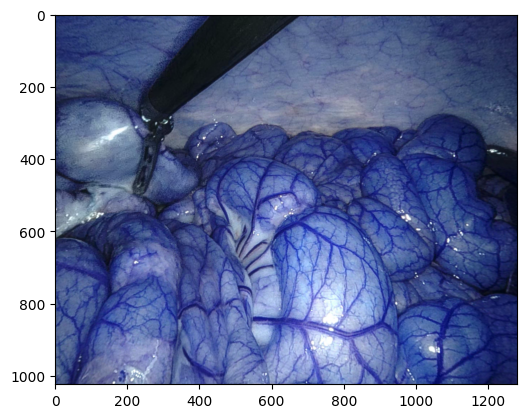

In [75]:
import matplotlib.pyplot as plt
plt.imshow(img_resized)

In [32]:
## no GRN,w/ Depth,rand init),100\%Gauss , 35.6458  ,  0.9789  ,  0.0673 , 1.5157, 115113 , 37.3969  ,  0.9912  ,  0.0338 , 1.6883, 117827\\
## no GRN,no Depth),100\%Gauss           , 33.1386  ,  0.9651  ,  0.0742 , 2.8108, 90645  , 36.2283  ,  0.9885  ,  0.0251 , 2.7306, 94526 \\
## no GRN, w/SD),100\%Gauss              , 35.6458  ,  0.9789  ,  0.0673 , 1.5157, 115113 , 38.8557  ,  0.9940  ,  0.0103 , 2.2322, 143256\\
## w/ GRN, w/SD),100\%Gauss              , 36.7405  ,  0.9820  ,  0.0355 , 2.0480, 108967 , 38.5460  ,  0.9931  ,  0.0162 , 2.1136, 114047\\
## w/ GRN, w/SD),10\%Gauss               , 36.1126  ,  0.9791  ,  0.0519 , 2.7710, 11813  , 37.6966  ,  0.9914  ,  0.0253 , 2.8073, 13753\\
## w/o GRN, w/SD),10\%Gauss              , 36.7637  ,  0.9833  ,  0.0317 , 2.6277, 41089  , 38.4466  ,  0.9931  ,  0.0130 , 2.6205, 48485\\
## w/ GRN, w/SD),1\%Gauss                , 34.2906  ,  0.9671  ,  0.1181 , 3.1629, 1894   , 34.7402  ,  0.9803  ,  0.1036 , 3.1959, 3017\\
## w/o GRN, w/SD),1\%Gauss               , 33.1964  ,  0.9349  ,  0.1038 , 3.0525, 13872  , 36.6134  ,  0.9732  ,  0.0462 , 2.9512, 19836\\

import numpy as np

a = np.array([33.1964  ,  0.9349  ,  0.1038 , 3.0525, 13872])*63
b = np.array([36.6134  ,  0.9732  ,  0.0462 , 2.9512, 19836])*156
# c = np.array([28.0204  ,  0.9190  ,  0.0710])*401
# d = np.array([30.8538  ,  0.9620  ,  0.0588])*326


avg = (a+b)/(63+156)
print('{:.2f}  & {:.2f}& {:.2f} & {:.2f}&{:.0f}'.format(avg[0],avg[1],avg[2],avg[3],avg[4]))

35.63  & 0.96& 0.06 & 2.98&18120


In [33]:
36.89  & 0.99& 0.04 & 1.64&117046
35.34  & 0.98& 0.04 & 2.75&93410
37.93  & 0.99& 0.03 & 2.03&135160
38.03  & 0.99& 0.02 & 2.09&112586
37.24  & 0.99& 0.03 & 2.80&13195
37.96  & 0.99& 0.02 & 2.62&46357
34.61  & 0.98& 0.11 & 3.19&2694
35.63  & 0.96& 0.06 & 2.98&18120

TypeError: unsupported operand type(s) for &: 'float' and 'float'

In [63]:
import torch
import lpips
import os
import glob
import cv2
import numpy as np
from pytorch_msssim import ms_ssim
from PIL import Image

lpips_model = lpips.LPIPS(net='alex')


def calculate_psnr(img1, img2):
    """Calculates the PSNR between two images.

    Args:
        img1: The first image: ndarray.
        img2: The second image: ndarray.

    Returns:
        The PSNR between the two images.
    """

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # Avoid division by zero
    psnr = 10 * np.log10(255 ** 2 / mse)
    return psnr

def calculate_ssim(img1, img2):
    """
    Calculates the MS-SSIM between two images using PyTorch.

    Args:
        img1: The first image: ndarray.
        img2: The second image: ndarray.

    Returns:
        The MS-SSIM between the two images.
    """
    
    if np.max(img1) > 1:
        img1 = img1/255.0
        img2 = img2/255.0
    img1_tensor = torch.from_numpy(img1.transpose(2, 0, 1)).unsqueeze(0).float()
    img2_tensor = torch.from_numpy(img2.transpose(2, 0, 1)).unsqueeze(0).float()
    ms_ssim_value = ms_ssim(img1_tensor, img2_tensor, data_range=1.0)
    return ms_ssim_value



def calculate_lpips(img1, img2):
    """Calculates the LPIPS between two images.

    Args:
        img1: The first image: ndarray.
        img2: The second image: ndarray.

    Returns:
        The LPIPS between the two images.
    """
    
    if np.max(img1) > 1:
        img1 = img1/255.0
        img2 = img2/255.0
        
    img1_tensor = torch.from_numpy(img1.transpose(2, 0, 1)).unsqueeze(0).float()
    img2_tensor = torch.from_numpy(img2.transpose(2, 0, 1)).unsqueeze(0).float()
    with torch.no_grad():
        lpips_distance = lpips_model(img1_tensor, img2_tensor)
    return lpips_distance.item()

def lsFile(folder_path, ext='png'):
    """
    bash like ls command to list files in a folder with a specific extension.
    """
    search_pattern = os.path.join(folder_path, '*.'+ext)
    files = glob.glob(search_pattern)
    sorted_files = sorted(files)
    return sorted_files

def rgb_metrics(gt, render):
    """
    Calculates the Peak Signal-to-Noise Ratio (PSNR), Multi-Scale Structural Similarity Index (MS-SSIM), and Learned Perceptual Image Patch Similarity (LPIPS) metrics for RGB images between the ground truth and rendered images.

    Args:
        gt: The base directory containing 'color' subfolder for ground truth RGB images.
        render: The comparison directory containing 'color' subfolder for rendered RGB images.

    Returns:
        mean_psnr: The mean PSNR value across all compared RGB image pairs.
        mean_ssim: The mean MS-SSIM value across all compared RGB image pairs.
        mean_lpips: The mean LPIPS value across all compared RGB image pairs.
        psnr_list: A list of PSNR values for each pair of compared RGB images.
        ssim_list: A list of MS-SSIM values for each pair of compared RGB images.
        lpips_list: A list of LPIPS values for each pair of compared RGB images.
    """

    color_gt = os.path.join(gt, 'images')
    color_render = os.path.join(render, 'color')
    # color_files1 = lsFile(color_gt)[7::8]
    # color_files2 = lsFile(color_render)
    color_files1 = sorted(os.listdir(color_gt))[7::8]
    color_files2 = sorted(os.listdir(color_render))
    # print(color_files1)
    # print(color_files2)
    if '0000' in color_files2[0]:
        color_files2 = color_files2[7::8]


    color1 = [cv2.imread(os.path.join(gt,'images',image_path), cv2.IMREAD_COLOR).astype(np.float32) for image_path in color_files1]
    color2 = [cv2.imread(os.path.join(render,'color',image_path), cv2.IMREAD_COLOR).astype(np.float32) for image_path in color_files2]
    color1 = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in color1]
    color2 = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in color2]
    color1 = [cv2.resize(image,(336,336)) for image in color1]
    color2 = [cv2.resize(image,(336,336)) for image in color2]
    
    psnr_list = [calculate_psnr(color1[i], color2[i]) for i in range(len(color1))]
    ssim_list = [calculate_ssim(color1[i], color2[i]) for i in range(len(color1))]
    lpips_list = [calculate_lpips(color1[i], color2[i]) for i in range(len(color1))]
    mean_psnr = np.mean(psnr_list)
    mean_ssim = np.mean(ssim_list)
    mean_lpips = np.mean(lpips_list)  

    return mean_psnr, mean_ssim, mean_lpips, psnr_list, ssim_list, lpips_list,color1,color2

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [64]:
mean_psnr, mean_ssim, mean_lpips, psnr_list, ssim_list, lpips_list ,color1,color2= rgb_metrics('data/endonerf_cutting','experiments/EndoNerf cutting_SurgeDepth_GRN/cutting_SurgeDepth_GRN/eval')
print(mean_psnr,mean_ssim,mean_lpips)

32.67380232732851 0.97465056 0.034588936030080446


In [66]:
color1[0]

array([[[118.97619 ,  66.046486,  75.046486],
        [118.311226,  63.59694 ,  73.386055],
        [123.04762 ,  66.88946 ,  77.24093 ],
        ...,
        [129.2619  ,  56.931404,  32.669502],
        [129.90475 ,  57.9983  ,  34.285713],
        [130.38039 ,  58.85771 ,  36.      ]],

       [[121.668365,  70.23979 ,  78.09864 ],
        [121.78571 ,  68.64285 ,  77.35204 ],
        [120.85884 ,  66.43027 ,  74.85884 ],
        ...,
        [129.58844 ,  55.746597,  32.318024],
        [131.70918 ,  58.719387,  34.566326],
        [131.88264 ,  58.42857 ,  35.644558]],

       [[120.068596,  68.14286 ,  74.14286 ],
        [120.38095 ,  66.984695,  73.67517 ],
        [117.424034,  63.18594 ,  70.185936],
        ...,
        [129.1287  ,  54.509636,  30.209751],
        [130.57823 ,  56.268707,  31.887754],
        [131.85999 ,  57.41043 ,  33.5771  ]],

       ...,

       [[ 18.690475,  47.550453,  70.07143 ],
        [ 19.073128,  47.627552,  70.56463 ],
        [ 20.271542,  

32.7819612741028

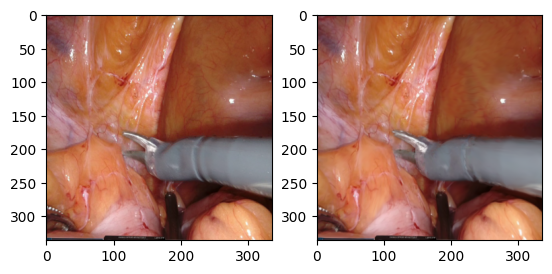

In [69]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2)
ax[0].imshow(color1[0]/255)
ax[1].imshow(color2[0]/255)


calculate_psnr(color1[0], color2[0])

In [89]:
psnr_list

[32.7819612741028,
 31.859355817706863,
 35.70150958085322,
 33.123649245953416,
 29.61199585116434,
 32.07613423868899,
 36.29056178285639,
 32.3373575047891,
 33.054056734302534,
 29.600204621300218,
 30.731413611245078,
 31.514503696563956,
 34.285633325944616,
 35.478163669756306,
 34.448890856428704,
 35.06016684322674,
 33.85007802711491,
 31.375519804895504,
 27.621087732347952]

In [88]:
def calc_psnr(img1, img2):
    mse = ((img1 - img2) ** 2).view(img1.shape[0], -1).mean(1, keepdim=True)
    return 20 * torch.log10(1**2 / torch.sqrt(mse))

calc_psnr(torch.tensor(color1[0]/255), torch.tensor(color2[0])/255).mean()

tensor(34.2159)

In [75]:
((color1[0]-color2[0])**2).mean()

34.267643

In [ ]:
import json

base_path = '/media/thesis_ssd/data/SCARED/dataset_4/keyframe_3/data/frame_data/'
paths = sorted(os.listdir(base_path))

# Open and read the JSON file
with open('data/SCARED_LONG/dataset_4/keyframe_3/pose.txt','w') as pose_file:
    for path in paths
        with open(os.path.join(base_path,path), 'r') as file:
            data = json.load(file)
            pose = [item for lst in data['camera-pose'] for item in lst]

        pose_file.write(f'{pose}\n')


